In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import time

from astropy import units as u
from astropy.visualization import quantity_support
import astropy.coordinates as coord
quantity_support()

from libstarcam import (
    InterpolatableTable,
    Filter, Lens, Sensor, StarCamera,
    get_filter_transmission, get_optics_transmission,
    calc_limiting_mag,
    get_tycho_stars,
    get_median_Teff,
    get_model_flux_density,
    get_zero_point_flux, # in beta
    get_equivalent_mag, # in beta
    simple_snr_spectral
)

%matplotlib widget

Could not import regions, which is required for some of the functionalities of this module.


Rapidly explore different combinations of sensors, lenses, and filters to build the optimal star camera.

In [2]:
lambd = np.arange(400, 1205, 5) * u.nm

# filter library
# Tycho2 V
lambd_dat, tau = np.genfromtxt('./TYCHO_TYCHO.V.dat', dtype=float, unpack=True)
lambd_dat = (lambd_dat * u.angstrom).to(u.nm)
F0 = (3.99504e-9 * u.erg / u.s / u.cm**2 / u.angstrom).to(u.W / u.cm**2 / u.um)
tycho_v = Filter(F0, tau_table=InterpolatableTable(lambd_dat, tau), name='Tycho V')

# A good initial guess
F0 = 1.2e-12 * u.W / (u.cm**2) / u.um # I-band, McLean 2008, Table 9.4
nofilter = Filter(F0)

red620 = Filter(
    F0,
    tau_table=InterpolatableTable(lambd, get_filter_transmission(lambd, center=620*u.nm, width=7*u.nm, max_transmission=0.9)),
    cost=73.,
    name='red620'
)
red695 = Filter(
    F0,
    tau_table=InterpolatableTable(lambd, get_filter_transmission(lambd, center=695*u.nm, width=7*u.nm, max_transmission=0.9)),
    cost=140.,
    name='red695'
)
black760 = Filter(
    F0,
    tau_table=InterpolatableTable(lambd, get_filter_transmission(lambd, center=760*u.nm, width=7*u.nm, max_transmission=0.9)),
    cost=40.,
    name='black760'
)
black850 = Filter(
    F0,
    tau_table=InterpolatableTable(lambd, get_filter_transmission(lambd, center=850*u.nm, width=7*u.nm, max_transmission=0.9)),
    cost=100.,
    name='black850'
) # https://www.bhphotovideo.com/c/product/1688039-REG/kolari_72mmk850_01_72mm_850nm_filter.html
black950 = Filter(
    F0,
    tau_table=InterpolatableTable(lambd, get_filter_transmission(lambd, center=950*u.nm, width=7*u.nm, max_transmission=0.9)),
    cost=34.,
    name='black950'
)
interference1000 = Filter(
    F0,
    tau_table=InterpolatableTable(lambd, get_filter_transmission(lambd, center=1000*u.nm, width=7*u.nm, max_transmission=0.9)),
    cost=130.,
    name='interference1000'
) # https://www.bhphotovideo.com/c/search?q=infrared%20filter%2072mm&sts=ma

assorted_filters = [red620, black760, black850, black950, interference1000]

 # helpful for testing things as a function of cutoff frequency
filter_array = [Filter(
    F0,
    tau_table=InterpolatableTable(lambd, get_filter_transmission(lambd, center=l, width=7*u.nm, max_transmission=0.9)),
    name=str(l.value)
) for l in lambd[::5]]

# lens library
# most prices are used market
canon_200_28 = Lens(
    200 * u.mm,
    200 * u.mm / 2.8,
    InterpolatableTable(lambd, get_optics_transmission(lambd)),
    name='Canon 200mm f/2.8',
    cost=443.
)
canon_200_2 = Lens(
    200 * u.mm,
    200 * u.mm / 2,
    InterpolatableTable(lambd, get_optics_transmission(lambd)),
    name='Canon 200mm f/2',
    cost=2900.
)
canon_135_2 = Lens(
    135 * u.mm,
    135 * u.mm / 2,
    InterpolatableTable(lambd, get_optics_transmission(lambd)),
    name='Canon 135mm f/2',
    cost=332.,
)
canon_85_12 = Lens(
    85 * u.mm,
    85 * u.mm / 1.2,
    InterpolatableTable(lambd, get_optics_transmission(lambd)),
    name='Canon 85mm f/1.2',
    cost=829.
)
canon_85_18 = Lens(
    85 * u.mm,
    85 * u.mm / 1.8,
    InterpolatableTable(lambd, get_optics_transmission(lambd)),
    name='Canon 85mm f/1.8',
    cost=209.
)
canon_50_12 = Lens(
    50 * u.mm,
    50 * u.mm / 1.2,
    InterpolatableTable(lambd, get_optics_transmission(lambd)),
    name='Canon 50mm f/1.2',
    cost=650.
)
sigma_135_18 = Lens(
    135 * u.mm,
    135 * u.mm / 1.8,
    InterpolatableTable(lambd, get_optics_transmission(lambd)),
    name='Sigma 135mm f/1.8 DG HSM',
    cost=1399., # MSRP
)
m12_50_28 = Lens(
    50 * u.mm,
    50 * u.mm / 2.8,
    InterpolatableTable(lambd, get_optics_transmission(lambd)),
    name='IR CAM 50mm f/2.8',
    cost=30.
)

# sensor library
ui_3260 = Sensor(
    (1936, 1216),
    5.86 * u.um,
    0.35/u.s, # http://neutronoptics.com/soft/Manual-NeutronOptics-FLIR-CMOS-Camera.pdf
    21,
    31800 * u.electron / u.pix,
    8,
    qe_table=InterpolatableTable(
        np.array([400, 500, 600, 650, 700, 750, 800, 1000, 1100, 1200]) * u.nm,
        np.array([0.58, 0.77, 0.61, 0.5, 0.39, 0.29, 0.2, 0.03, 0.0, 0.0])
    ),
    cost=688.,
    name='iDS uEye UI-3260-CP-M-GL'
) # https://en.ids-imaging.com/store/ui-3260cp-rev-2.html
u3_31n0se = Sensor(
    (5328,3040),
    2.74*u.um,
    1.38/u.s, # https://thinklucid.com/product/triton-16-2-mp-imx542/?srsltid=AfmBOorWeS_UYDtT8ZuoNhhgyEVhc7NRxoBQiFOYLiM8PHZ1PaTqk6eL
    1, # https://www.ximea.com/products/usb-vision-industrial/xic-sony-cmos-pregius-usb3-cameras/sony-imx542-usb3-color-industrial-camera
    9465 * u.electron / u.pix,
    8, # real capability is 12-bit, but we might run in 8-bit for software reasons
    qe_table=InterpolatableTable(
        np.array([400, 500, 600, 650, 700, 750, 800, 1000, 1100, 1200]) * u.nm,
        np.array([0.62, 0.72, 0.6, 0.53, 0.43, 0.34, 0.24, 0.04, 0.0, 0.0])
    ),
    cost=1700.,
    name='iDS uEye U3-31N0SE-M-GL'
) # https://en.ids-imaging.com/store/u3-31n0se-rev-1-2.html
ov9281 = Sensor(
    (1280,800),
    3*u.um,
    1/u.s, # not listed
    3.2,
    14000. * u.electron / u.pix, # not documented anywhere
    10,
    qe_table=InterpolatableTable(
        np.array([400, 500, 600, 700, 800, 900, 1000, 1100, 1200]) * u.nm,
        0.8 * np.array([0.50, 0.92, 1.0, 0.83, 0.56, 0.30, 0.08, 0.0, 0.0]) # relative curve only, assume peak 80%
    ),
    cost=30.,
    name='OV9281'
)
asi220mm = Sensor(
    (1920,1080),
    4*u.um,
    1/u.s, # not listed
    3.2,
    8.78e3 * u.electron / u.pix,
    12,
    qe_table=InterpolatableTable(
        np.array([400, 500, 600, 700, 800, 900, 1000, 1100, 1200]) * u.nm,
        np.array([0.86, 0.92, 0.86, 0.75, 0.57, 0.38, 0.16, 0.0, 0.0])
    ),
    cost=249.,
    name='ZWO ASI220MM'
) # https://www.zwoastro.com/product/zwo-asi220mm-minimono/
asi183mm = Sensor(
    (5496,3672),
    2.4*u.um,
    1.56/u.s, # @30 C, also the max measured value
    1.6,
    15e3 * u.electron / u.pix,
    12,
    qe_table=InterpolatableTable(
        np.array([400, 500, 600, 650, 700, 750, 800, 1000, 1100, 1200]) * u.nm,
        0.84 * np.array([0.7, 0.96, 0.93, 0.8, 0.73, 0.45, 0.25, 0.09, 0.0, 0.0])
    ),
    cost=999.,
    name='ZWO ASI183MM'
) # https://www.zwoastro.com/product/asi183mm-mc/
asi294mm = Sensor( # hardware binning 2x
    (4144,2822),
    4.64*u.um,
    0.185/u.s, # copied from qhy model below
    1.2,
    14.4e3 * u.electron / u.pix,
    14,
    qe_table=InterpolatableTable(
        np.array([400, 500, 600, 700, 800, 900, 1000, 1100, 1200]) * u.nm,
        np.array([0.64, 0.89, 0.86, 0.66, 0.44, 0.3, 0.1, 0.0, 0.0])
    ), # https://www.highpointscientific.com/media/wysiwyg/zwo-asi294mm-peak-qe_1.jpg
    cost=699.,
    name='ZWO ASI294MM (IMX492)'
) # https://www.zwoastro.com/product/asi294mm-mc/
qhy294m = Sensor(
    (4164,2796),
    4.63*u.um,
    0.185/u.s,
    6.34,
    15655 * u.electron / u.pix,
    12,
    qe_table=InterpolatableTable(
        np.array([400, 500, 600, 700, 800, 900, 1000, 1100, 1200]) * u.nm,
        np.array([0.7489, 0.8555, 0.6699, 0.4069, 0.2478, 0.1048, 0.0036, 0.0, 0.0])
    ), # https://thinklucid.com/product/atlas10-47mp-imx492/?srsltid=AfmBOopZ_X-HADsVjUXdADE_B9aT_rG-wxSMF7FPXXMrn-KGeBVtj6wP
    cost=1299.,
    name='QHY294M (IMX492)'
) # https://www.qhyccd.com/astronomical-camera-qhy294/
qhy5iii585m = Sensor(
    (3856,2180),
    2.9*u.um,
    0.518/u.s, # @30 C, the max
    8,
    54e3 * u.electron / u.pix,
    12,
    qe_table=InterpolatableTable(
        np.array([400, 500, 600, 700, 800, 900, 1000, 1100, 1200]) * u.nm,
        np.array([0.91, 0.91, 0.88, 0.76, 0.58, 0.38, 0.16, 0.0, 0.0])
    ), # https://www.qhyccd.com/minicam8/
    cost=349.,
    name='QHY5III585M (IMX585)'
) # https://www.qhyccd.com/qhy5iii585/
qhy268 = Sensor(
    (6252,4176),
    3.76*u.um,
    0.0369/u.s, # @20 C, the max
    3.5,
    51e3 * u.electron / u.pix,
    16,
    qe_table=InterpolatableTable(
        np.array([400, 500, 600, 700, 800, 900, 1000, 1100, 1200]) * u.nm,
        np.array([0.72, 0.90, 0.72, 0.46, 0.28, 0.15, 0.04, 0.0, 0.0])
    ), # https://www.qhyccd.com/astronomical-camera-qhy268/
    cost=2399.,
    name='QHY268M'
) # https://www.qhyccd.com/astronomical-camera-qhy268/
qhy533 = Sensor(
    (3008,3028),
    3.76*u.um,
    0.0005/u.s, # @-20 C, no other data/I'm lazy/doesn't matter
    3.4,
    58e3 * u.electron / u.pix,
    14,
    qe_table=InterpolatableTable(
        np.array([400, 500, 600, 700, 800, 900, 1000, 1100, 1200]) * u.nm,
        np.array([0.72, 0.90, 0.72, 0.46, 0.28, 0.15, 0.04, 0.0, 0.0])
    ), # https://www.qhyccd.com/astronomical-camera-qhy533/, same QE as 268?
    cost=1099.,
    name='QHY533M'
) # https://www.qhyccd.com/astronomical-camera-qhy533/
qhy183 = Sensor(
    (5544,3684),
    2.4*u.um,
    0.062/u.s, # @15 C, the max
    2.7,
    15.5e3 * u.electron / u.pix,
    16,
    qe_table=InterpolatableTable(
        np.array([400, 500, 600, 700, 800, 900, 1000, 1100, 1200]) * u.nm,
        np.array([0.74, 0.84, 0.65, 0.43, 0.24, 0.11, 0.04, 0.0, 0.0])
    ), # https://cloudbreakoptics.com/blogs/news/product-review-the-qhy-183c
    cost=999.,
    name='QHY183M (IMX183)'
) # https://www.qhyccd.com/astronomical-camera-qhy183/
triton2_swir = Sensor(
    (2560, 2048),
    3.45*u.um,
    26800/u.s, # @ 49 C
    122, # https://www.qhyccd.com/scientific-camera-qhy990_qhy991_qhy992/
    52e3 * u.electron / u.pix,
    12,
    qe_table=InterpolatableTable(
        np.array([400, 450, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800]) * u.nm,
        np.array([0.61, 0.68, 0.68, 0.53, 0.56, 0.62, 0.68, 0.71, 0.745, 0.74, 0.74, 0.72, 0.69, 0.645, 0.08, 0.0])
    ), # https://www.axiomoptics.com/products/alvium-vswir-uncooled-ingaas-cameras/
    cost=20400.,
    name='Triton2 SWIR (IMX992)'
) # https://thinklucid.com/product/triton2-swir-5-2mp-model-imx992/

In [3]:
SC1 = StarCamera(ui_3260, canon_200_28, nofilter, name='SC1')
SC2 = StarCamera(ui_3260, canon_200_28, red620, name='SC2')

tim_prime = StarCamera(u3_31n0se, canon_200_28, black760, name='tim-prime')
tim_wide = StarCamera(ui_3260, canon_85_12, black760, name='TIM-wide')
tim_prime_wide = StarCamera(u3_31n0se, canon_85_12, black760, name='tim-prime-wide')

cam_zwo183m = StarCamera(asi183mm, canon_200_28, red620, name='candidate-zwo183m')
cam_zwo294m = StarCamera(asi294mm, canon_200_28, red620, name='candidate-zwo294m')
cam_zwo294m_wide = StarCamera(asi294mm, canon_85_12, red695, name='candidate-zwo294m-wide')
cam_qhy294m = StarCamera(qhy294m, canon_200_28, red620, name='candidate-qhy294m')
cam_qhy5iii585m = StarCamera(qhy5iii585m, canon_200_28, red620, name='candidate-qhy5iii585m')
cam_qhy5iii585m_wide = StarCamera(qhy5iii585m, canon_135_2, red620, name='candidate-qhy5iii5m-wide')
cam_qhy268m = StarCamera(qhy268, canon_200_28, red620, name='candidate-qhy268m')
cam_qhy533m = StarCamera(qhy533, canon_200_28, red620, name='candidate-qhy533m')
cam_qhy183m = StarCamera(qhy183, canon_200_28, red620, name='candidate-qhy183m')
cam_swir = StarCamera(triton2_swir, canon_135_2, black850, name='swir')
cam_swir_wide = StarCamera(triton2_swir, canon_85_12, black850, name='swir-wide')
cam_swir_ultrawide = StarCamera(triton2_swir, canon_50_12, black850, name='swir-ultrawide')

cams = [
    # SC1,
    SC2,
    tim_wide,
    tim_prime,
    tim_prime_wide,
    # cam_zwo183m,
    # cam_zwo294m,
    # cam_zwo294m_wide,
    # cam_qhy294m,
    # cam_qhy5iii585m,
    # cam_qhy5iii585m_wide,
    # cam_qhy533m,
    # cam_qhy183m,
    # cam_swir,
    # cam_swir_wide,
    # cam_swir_ultrawide,
    # cam_guide
]

## Sensor Properties Comparison

### Spectral Characteristics

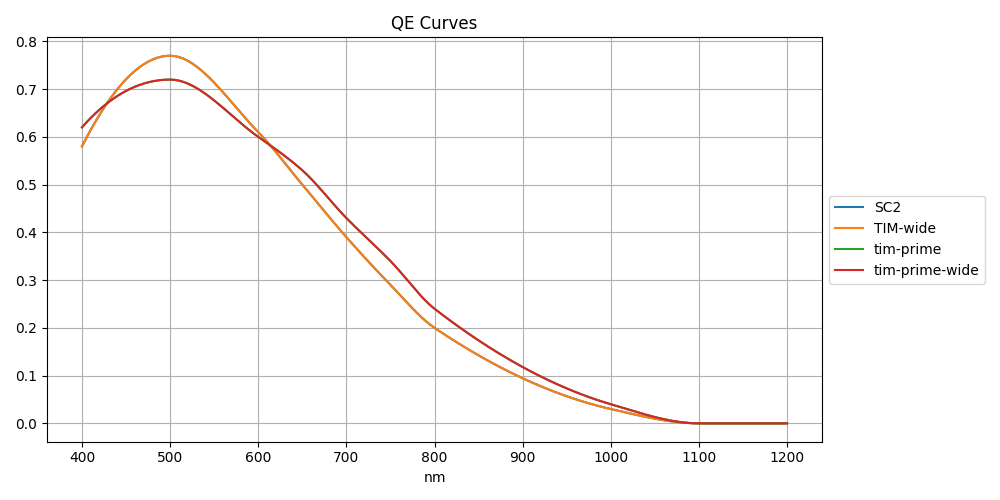

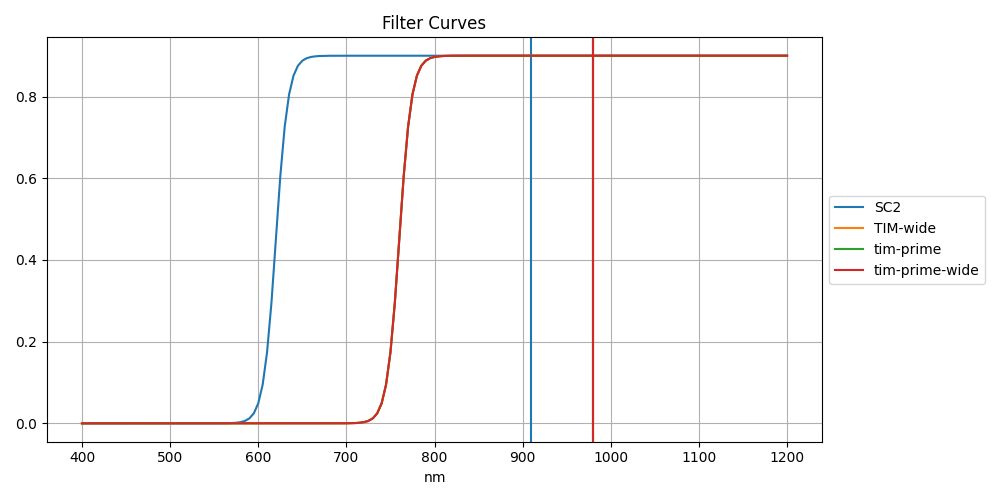

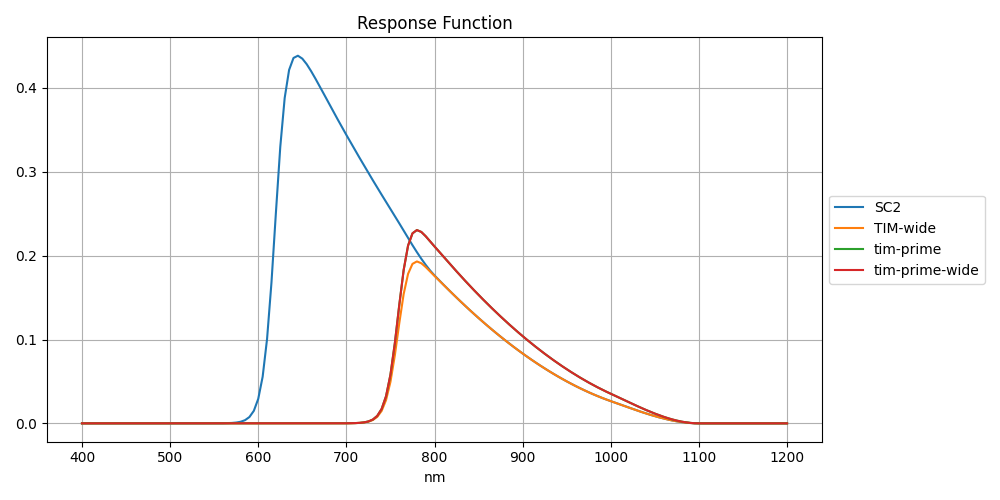

In [4]:
fig, ax = plt.subplots(figsize=(10,5))
for cam in cams:
    color = next(ax._get_lines.prop_cycler)['color']
    ax.plot(lambd, cam.sensor.qe(lambd), color=color, label=cam.name)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid()
ax.set_title('QE Curves')
fig.tight_layout()

fig, ax = plt.subplots(figsize=(10,5))
for cam in cams:
    color = next(ax._get_lines.prop_cycler)['color']
    ax.plot(lambd, cam.filter.tau(lambd), color=color, label=cam.name)
    ax.axvline(cam.get_mean_lambd(lambd), color=color)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid()
ax.set_title('Filter Curves')
fig.tight_layout()

fig, ax = plt.subplots(figsize=(10,5))
for cam in cams:
    ax.plot(lambd, cam.get_response(lambd), label=cam.name)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid()
ax.set_title('Response Function')
fig.tight_layout()

### Sensor Size

SC2: [3.24922057 2.04116396] deg -> 6.632191936197747 deg2, plate scale: [6.04193907 6.04291963] arcsec / pix
TIM-wide: [7.63595212 4.80043666] deg -> 36.655904471411944 deg2, plate scale: [14.19908452 14.21181905] arcsec / pix
tim-prime: [4.18036976 2.38590979] deg -> 9.97398514624117 deg2, plate scale: [2.82457416 2.82541949] arcsec / pix
tim-prime-wide: [9.81644677 5.61023001] deg -> 55.07252426580622 deg2, plate scale: [6.6327343  6.64369344] arcsec / pix


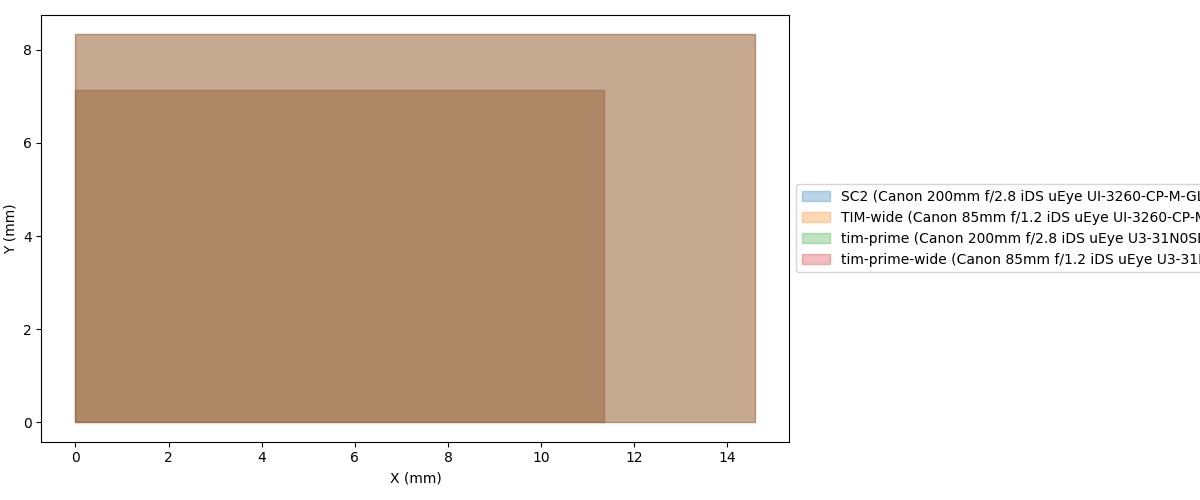

In [5]:
fig, ax = plt.subplots(figsize=(12,5))
for i, cam in enumerate(cams):
    ax.add_artist(
        Rectangle(
            (0, 0),
            cam.sensor.sensor_size[0].value,
            cam.sensor.sensor_size[1].value,
            color=f'C{i}',
            label=f'{cam.name} ({cam.lens.name} {cam.sensor.name})',
            alpha=0.3
        ),
    )
    print(f'{cam.name}: {cam.fov} -> {cam.fov[0] * cam.fov[1]}, plate scale: {cam.plate_scale}')
ax.relim()
ax.autoscale_view()
ax.set_aspect('equal')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
fig.tight_layout()

### FoV and Plate Solving Performance

Rough initial estimates can be had using averages of star catalog abundances.

SC2: [3.24922057 2.04116396] deg -> 6.632191936197747 deg2 -> 3.3160959680988733 stars
TIM-wide: [7.63595212 4.80043666] deg -> 36.655904471411944 deg2 -> 18.327952235705972 stars
tim-prime: [4.18036976 2.38590979] deg -> 9.97398514624117 deg2 -> 4.986992573120585 stars
tim-prime-wide: [9.81644677 5.61023001] deg -> 55.07252426580622 deg2 -> 27.53626213290311 stars


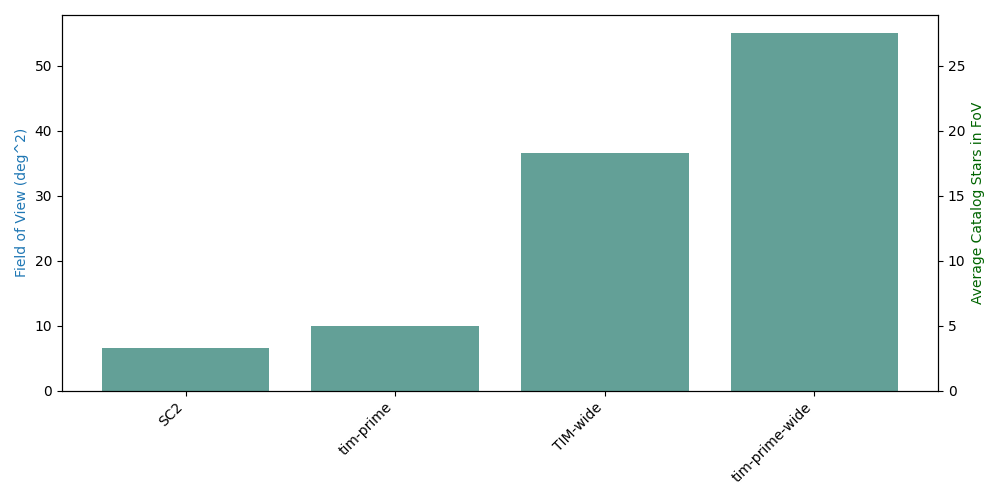

In [6]:
I_band_stars_per_deg2 = 0.5 / u.deg**2 # Alexander+ 1999, I-band estimate

fov_sort = np.argsort([(cam.fov[0] * cam.fov[1]).value for cam in cams])
fig, fov_area_ax = plt.subplots(figsize=(10,5))
fov_area_ax.bar(
    [cams[i].name for i in fov_sort],
    [cams[i].fov[0] * cams[i].fov[1] for i in fov_sort],
    color='C0',
    alpha=0.5
)
fov_area_ax.set_ylabel('Field of View (deg^2)')
fov_area_ax.yaxis.label.set_color('C0')
plt.xticks(rotation=45, ha='right')
avg_stars_ax = fov_area_ax.twinx()
avg_stars_ax.bar(
    [cams[i].name for i in fov_sort],
    [((cams[i].fov[0] * cams[i].fov[1]) * I_band_stars_per_deg2) for i in fov_sort],
    color='darkgreen',
    alpha=0.3
)
avg_stars_ax.set_ylabel('Average Catalog Stars in FoV')
avg_stars_ax.yaxis.label.set_color('darkgreen')
fig.tight_layout()

for cam in cams:
    print(f'{cam.name}: {cam.fov} -> {cam.fov[0] * cam.fov[1]} -> {(cam.fov[0] * cam.fov[1]) * I_band_stars_per_deg2} stars')

In [7]:
for cam in cams:
    print(f'{cam.name}, {cam.plate_scale}, {cam.lens.airy_diam(lambd).mean()}, {cam.lens.fwhm(lambd).mean()}')

SC2, [6.04193907 6.04291963] arcsec / pix, 5.636804625120648 arcsec, 2.3771606390365356 arcsec
TIM-wide, [14.19908452 14.21181905] arcsec / pix, 5.684172731214099 arcsec, 2.3971367788603724 arcsec
tim-prime, [2.82457416 2.82541949] arcsec / pix, 5.636804625120648 arcsec, 2.3771606390365356 arcsec
tim-prime-wide, [6.6327343  6.64369344] arcsec / pix, 5.684172731214099 arcsec, 2.3971367788603724 arcsec


Assume an observation near TIM science field, out of galactic plane, near GOODS-S. What stars do we see?

In [8]:
region = coord.SkyCoord(ra='3:32:39.55', dec='-27d47m6.40s', unit=(u.deg, u.deg), frame='icrs')
# region = coord.SkyCoord(ra='4:38:12.7', dec='21d39m05.2s', unit=(u.deg, u.deg), frame='icrs')

max_area = np.max([(cam.fov[0] * cam.fov[1]).value for cam in cams])
fovs = np.arange(2, np.ceil(np.sqrt(max_area)) + 1.0, 0.25) * u.deg
xs = []
hitss = []
ecdfs = []
for fov in fovs: # TODO: query only the largest region and crop in after query for subregions
    table = get_tycho_stars(region, fov, fov, mag_limit=10, nlimit=1000)
    hits = table['VTmag']
    hitss.append(hits)
    # https://stackoverflow.com/a/75545886
    x, CDF_counts = np.unique(hits, return_counts = True)
    y = np.cumsum(CDF_counts)
    xs.append(x)
    ecdfs.append(y)
    print(fov)
    # Be nice to Vizier.
    time.sleep(.5)

INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 2.0 degx2.0 deg


2.0 deg


INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 2.25 degx2.25 deg


2.25 deg


INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 2.5 degx2.5 deg


2.5 deg


INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 2.75 degx2.75 deg


2.75 deg


INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 3.0 degx3.0 deg


3.0 deg


INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 3.25 degx3.25 deg


3.25 deg


INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 3.5 degx3.5 deg


3.5 deg


INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 3.75 degx3.75 deg


3.75 deg


INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 4.0 degx4.0 deg


4.0 deg


INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 4.25 degx4.25 deg


4.25 deg


INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 4.5 degx4.5 deg


4.5 deg


INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 4.75 degx4.75 deg


4.75 deg


INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 5.0 degx5.0 deg


5.0 deg


INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 5.25 degx5.25 deg


5.25 deg


INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 5.5 degx5.5 deg


5.5 deg


INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 5.75 degx5.75 deg


5.75 deg


INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 6.0 degx6.0 deg


6.0 deg


INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 6.25 degx6.25 deg


6.25 deg


INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 6.5 degx6.5 deg


6.5 deg


INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 6.75 degx6.75 deg


6.75 deg


INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 7.0 degx7.0 deg


7.0 deg


INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 7.25 degx7.25 deg


7.25 deg


INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 7.5 degx7.5 deg


7.5 deg


INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 7.75 degx7.75 deg


7.75 deg


INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 8.0 degx8.0 deg


8.0 deg


INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 8.25 degx8.25 deg


8.25 deg


INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 8.5 degx8.5 deg


8.5 deg


INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 8.75 degx8.75 deg


8.75 deg


INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 8.75 degx8.75 deg


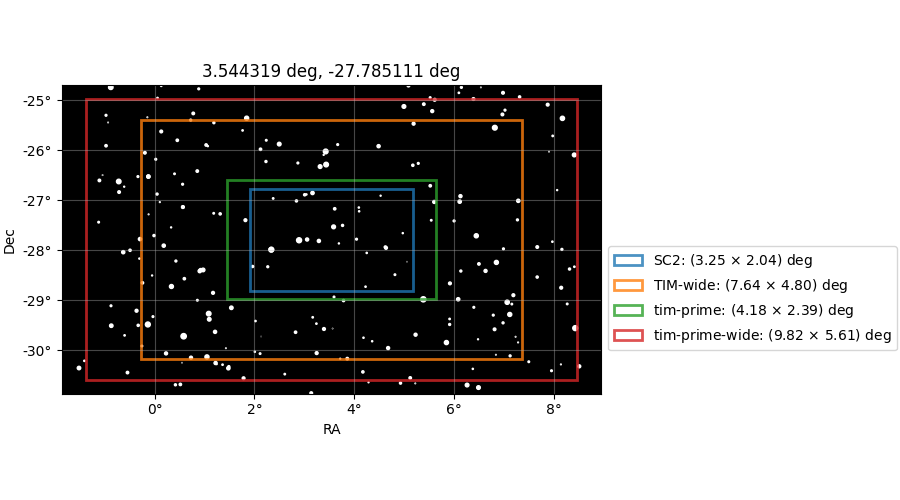

In [9]:
fig, ax = plt.subplots(figsize=(9,5))
ax.set_facecolor('k')

table = get_tycho_stars(region, fovs[-1], fovs[-1], mag_limit=10, nlimit=1000)
ra_wrapped = ((table['RAmdeg'] + 180.) % 360.) - 180.
ax.scatter(
    ra_wrapped,
    table['DEmdeg'],
    # c=table['VTmag'],
    s=15 - 15*(table['VTmag'] - table['VTmag'].min())/ (table['VTmag'].max() - table['VTmag'].min()),
    # cmap='bone_r'
    color='w'
)

for i, cam in enumerate(cams):
    rect = Rectangle(
        ((region.ra - cam.fov[0]/2).value, (region.dec-cam.fov[1]/2).value),
        cam.fov[0].value,
        cam.fov[1].value,
        facecolor='none',
        edgecolor=f'C{i}',
        linewidth=2,
        alpha=0.8,
        label=f'{cam.name}: ({cam.fov[0].to(u.deg).value:.2f} $\\times$ {cam.fov[1].to(u.deg).value:.2f}) deg'
    )
    ax.add_artist(rect)
ax.scatter(region.ra, region.dec, color='k', marker='+')

ax.set_title(f'{region.ra:.6f}, {region.dec:.6f}')
ax.relim()
ax.autoscale_view()
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.grid(alpha=0.4)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1, 0.5))
fig.tight_layout()

In [10]:
# Update the zero-point fluxes based on the stars in field and filters in use:
for cam in cams:
    F0_new = get_zero_point_flux(lambd, region, cam.fov[0], cam.fov[1], cam.filter)
    # print(F0_new)
    cam.filter.zero_point_flux = F0_new

INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 3.2492205683270936 degx2.0411639643203485 deg
INFO:root:Querying xMatch service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 3.2492205683270936 degx2.0411639643203485 deg, r=1.0 arcsec, vizier:I/355/paramp
/home/evanmayer/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 7.635952119314747 degx4.800436657884839 deg
INFO:root:Querying xMatch service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 7.635952119314747 degx4.800436657884839 deg, r=1.0 arcsec, vizier:I/355/paramp
/home/evanmayer/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition

### Signal-to-noise ratio

INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 3.2492205683270936 degx2.0411639643203485 deg
INFO:root:Querying xMatch service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 3.2492205683270936 degx2.0411639643203485 deg, r=1.0 arcsec, vizier:I/355/paramp
/home/evanmayer/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 7.635952119314747 degx4.800436657884839 deg
INFO:root:Querying xMatch service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 7.635952119314747 degx4.800436657884839 deg, r=1.0 arcsec, vizier:I/355/paramp
/home/evanmayer/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition

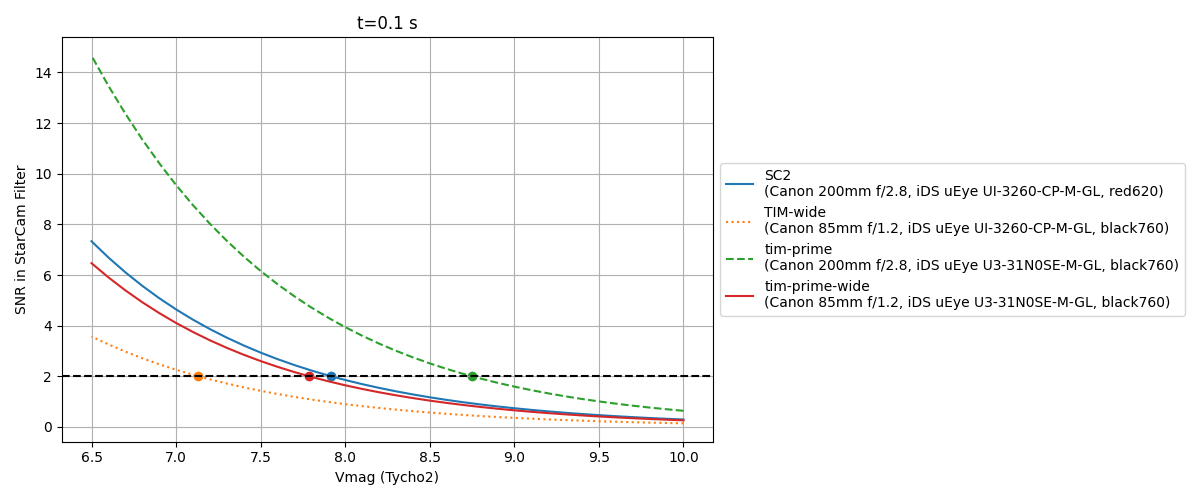

In [11]:
fig, ax = plt.subplots(figsize=(12,5))
linestyles = ['-', ':', '--']

t_exp = 0.1 * u.s
mags_Vtyc = np.arange(10., 6.4, -0.1)
snr_limit = 2
limiting_mags = {}
for i, cam in enumerate(cams):
    # convert tycho mags into our filter system mags for SNR calc in our filters
    Teff = get_median_Teff(region, cam.fov[0], cam.fov[1])
    model_curve = get_model_flux_density(Teff)
    mags = get_equivalent_mag(lambd, mags_Vtyc, tycho_v, cam.filter, model_curve)
    snrs = []
    for mag in mags:
        snr = simple_snr_spectral(t_exp, lambd, mag, cam)
        snrs.append(snr)
    l, = ax.plot(mags_Vtyc, snrs, label=f'{cam.name}\n({cam.lens.name}, {cam.sensor.name}, {cam.filter.name})', linestyle=linestyles[i%len(linestyles)])

    limiting_mag = calc_limiting_mag(snr_limit, mags_Vtyc, np.array(snrs))
    ax.scatter(limiting_mag, snr_limit, color=l.get_color())
    limiting_mags[cam] = limiting_mag

ax.axhline(snr_limit, linestyle='--', color='k')
# ax.axhline(5, linestyle=':', color='k')
ax.set_xlabel('Vmag (Tycho2)')
ax.set_ylabel('SNR in StarCam Filter')
ax.set_title(f't={t_exp:0.1f}')
ax.grid()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()

### Saturation

INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 3.2492205683270936 degx2.0411639643203485 deg
INFO:root:Querying xMatch service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 3.2492205683270936 degx2.0411639643203485 deg, r=1.0 arcsec, vizier:I/355/paramp
/home/evanmayer/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 7.635952119314747 degx4.800436657884839 deg
INFO:root:Querying xMatch service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 7.635952119314747 degx4.800436657884839 deg, r=1.0 arcsec, vizier:I/355/paramp
/home/evanmayer/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition

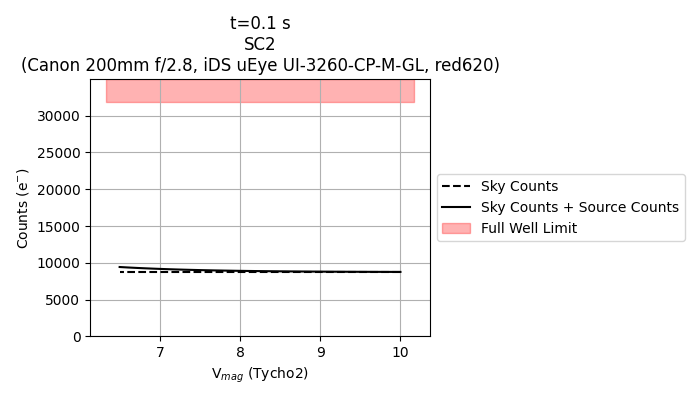

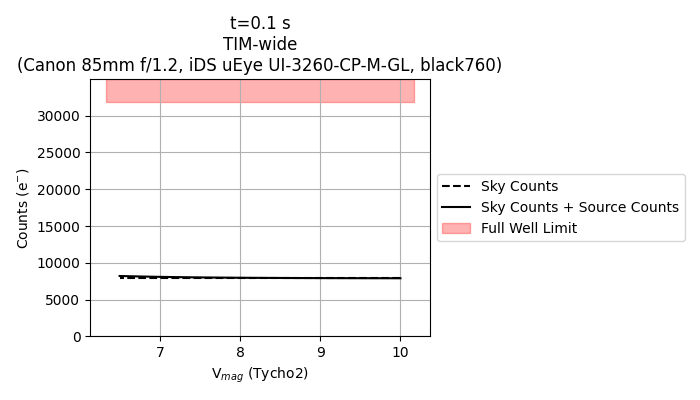

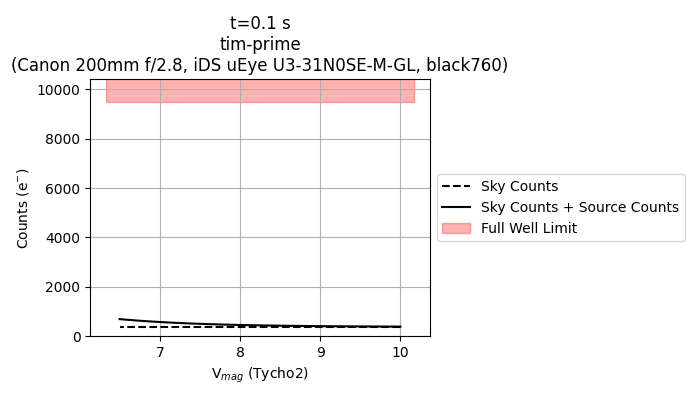

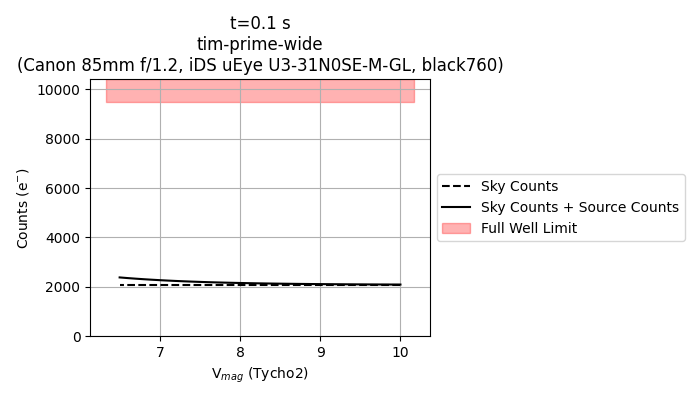

In [12]:
t_exp = 0.1 * u.s
mags_Vtyc = np.arange(10., 6.4, -0.1)
snr_limit = 2
for i, cam in enumerate(cams):
    fig, ax = plt.subplots(figsize=(7,4))
    Teff = get_median_Teff(region, cam.fov[0], cam.fov[1])
    model_curve = get_model_flux_density(Teff)
    mags = get_equivalent_mag(lambd, mags_Vtyc, tycho_v, cam.filter, model_curve)
    src = []
    sky = []
    summed = []
    for mag in mags:
        _, (source_electrons_per_sec, sky_electrons_per_sec, aperture_area_px) = simple_snr_spectral(t_exp, lambd, mag, cam, return_components=True)
        e_per_px_source = (t_exp / aperture_area_px) * source_electrons_per_sec
        e_per_px_sky = (t_exp / aperture_area_px) * sky_electrons_per_sec
        e_per_px = e_per_px_source + e_per_px_sky
        src.append(e_per_px_source.value)
        sky.append(e_per_px_sky.value)
        summed.append(e_per_px.value)

    ax.plot(mags_Vtyc, sky, color='k', linestyle='--', label='Sky Counts')
    ax.plot(mags_Vtyc, summed, color='k', label='Sky Counts + Source Counts')

    ax.set_ylim(0, 1.1 * max([cam.sensor.full_well.value, np.max(summed)]))
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    ax.fill_between([xmin, xmax], cam.sensor.full_well.value, y2=ymax, color='r', alpha=0.3, label='Full Well Limit')
    ax.set_xlabel('V$_{mag}$ (Tycho2)')
    ax.set_ylabel('Counts (e$^{-}$)')
    ax.set_title(f't={t_exp:0.1f}\n{cam.name}\n({cam.lens.name}, {cam.sensor.name}, {cam.filter.name})')
    ax.grid()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.tight_layout()

INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 3.2492205683270936 degx2.0411639643203485 deg
INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 7.635952119314747 degx4.800436657884839 deg
INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 4.180369763262014 degx2.38590979053927 deg
INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 9.816446765892575 degx5.610230012875608 deg


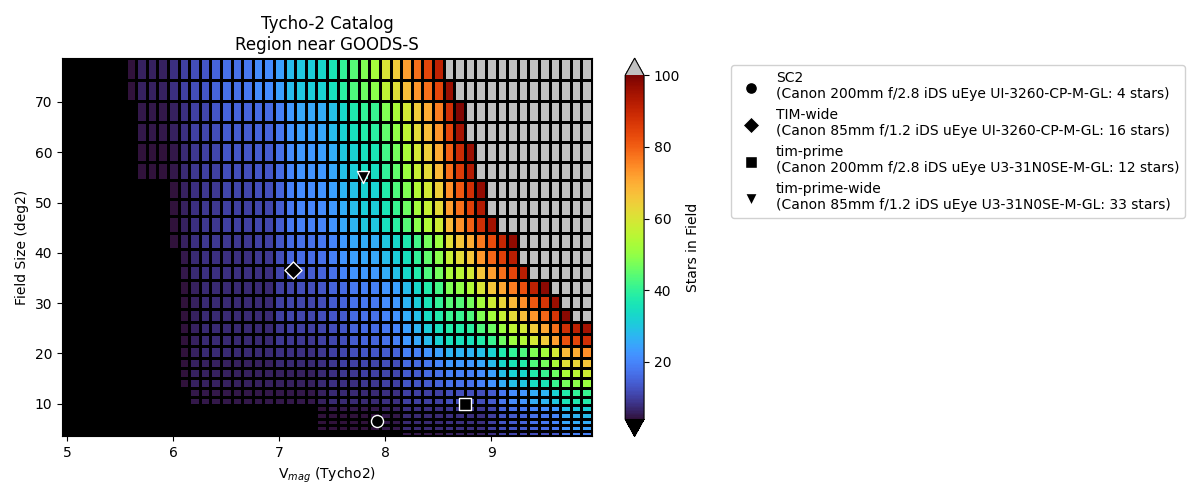

In [13]:
# Create a CDF heatmap in mag/fov-space for the number of stars in the catalog
magbins = np.arange(5, 10.1, 0.1)
countss = []
for i, fov in enumerate(fovs):
    h, b = np.histogram(hitss[i], bins=magbins)
    countss.append(np.cumsum(h))
X, Y = np.meshgrid(b[:-1], fovs**2)
Z = np.stack(countss)

fig, ax = plt.subplots(figsize=(12,5))
cmap = plt.get_cmap('turbo').copy()
cmap.set_extremes(under='k', over='silver')
im = ax.pcolormesh(X, Y, Z, edgecolors='k', vmin=4, vmax=100, cmap=cmap)
fig.colorbar(im, ax=ax, label='Stars in Field', extend='both')

# identify cameras in mag/FoV parameter space
marker_styles = ['o', 'D', 's', 'v', '^', '<', '>', '*']
for i, cam in enumerate(cams):
    limiting_mag = limiting_mags[cam]

    table = get_tycho_stars(region, cam.fov[0], cam.fov[1], mag_limit=limiting_mag, nlimit=1000)
    est_stars = len(table)

    ax.scatter(
        limiting_mag,
        (cam.fov[0] * cam.fov[1]),
        s=75,
        marker=marker_styles[i % len(marker_styles)],
        color='k',
        edgecolor='w',
        label=f'{cam.name}\n({cam.lens.name} {cam.sensor.name}: {est_stars} stars)'
    )
ax.legend(loc='upper left', facecolor='w', fontsize=10, framealpha=0.9, bbox_to_anchor=(1.25, 1.))
ax.set_title('Tycho-2 Catalog\nRegion near GOODS-S')
ax.set_xlabel('V$_{mag}$ (Tycho2)')
ax.set_ylabel('Field Size (deg2)')
ax.relim()
ax.autoscale_view()
fig.tight_layout()
plt.show()

### Filter Optimization

64032 electron / pix > 31800 electron / pix
sensor: iDS uEye UI-3260-CP-M-GL, lens: Canon 200mm f/2.8, filter: 400.0
67053 electron / pix > 31800 electron / pix
sensor: iDS uEye UI-3260-CP-M-GL, lens: Canon 200mm f/2.8, filter: 400.0
56682 electron / pix > 31800 electron / pix
sensor: iDS uEye UI-3260-CP-M-GL, lens: Canon 200mm f/2.8, filter: 425.0
59589 electron / pix > 31800 electron / pix
sensor: iDS uEye UI-3260-CP-M-GL, lens: Canon 200mm f/2.8, filter: 425.0
47751 electron / pix > 31800 electron / pix
sensor: iDS uEye UI-3260-CP-M-GL, lens: Canon 200mm f/2.8, filter: 450.0
50498 electron / pix > 31800 electron / pix
sensor: iDS uEye UI-3260-CP-M-GL, lens: Canon 200mm f/2.8, filter: 450.0
39200 electron / pix > 31800 electron / pix
sensor: iDS uEye UI-3260-CP-M-GL, lens: Canon 200mm f/2.8, filter: 475.0
41765 electron / pix > 31800 electron / pix
sensor: iDS uEye UI-3260-CP-M-GL, lens: Canon 200mm f/2.8, filter: 475.0
33786 electron / pix > 31800 electron / pix
sensor: iDS uEye UI-

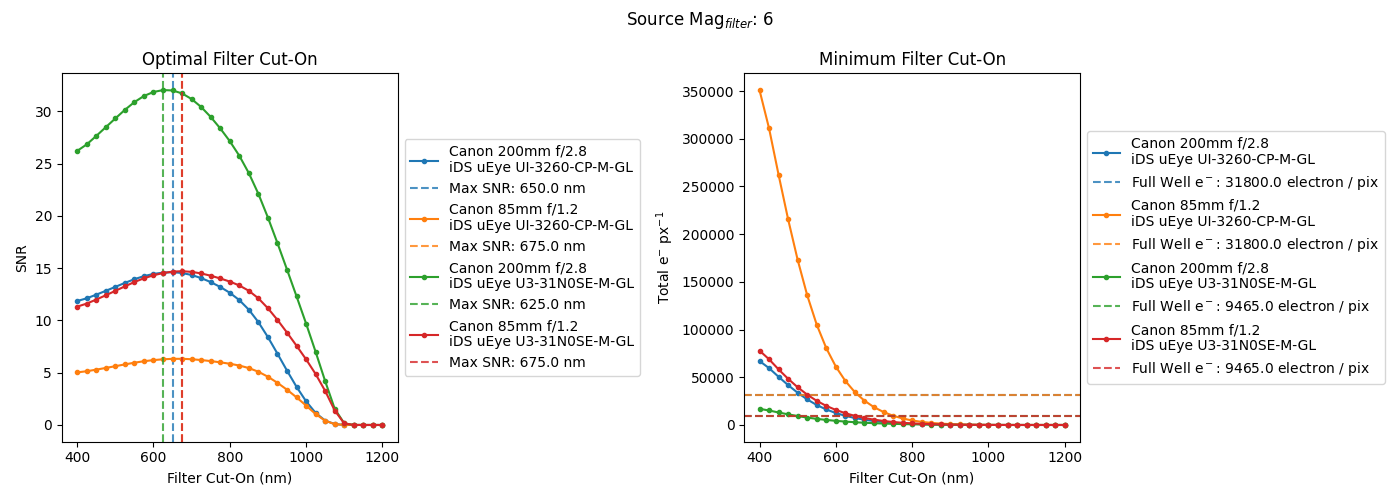

In [20]:
fig, (ax, ax1) = plt.subplots(figsize=(14,5), ncols=2, sharex=True)
mag = 6
fig.suptitle('Source Mag$_{filter}$: ' + f'{mag}')
for i, cam in enumerate(cams):
    snrs = []
    e_per_pxs = []
    for filt in filter_array:
        cam = StarCamera(cam.sensor, cam.lens, filt, name=f'{cam.sensor.name}-{filt.name}')
        snr, (source_electrons_per_sec, sky_electrons_per_sec, aperture_area_px) = simple_snr_spectral(t_exp, lambd, mag, cam, return_components=True)
        e_per_px_source = (t_exp / aperture_area_px) * source_electrons_per_sec
        e_per_px_sky = (t_exp / aperture_area_px) * sky_electrons_per_sec
        e_per_px = e_per_px_source + e_per_px_sky
        e_per_pxs.append(e_per_px.value)
        snrs.append(snr)
    ax.plot(
        [float(filter_array[i].name) for i in range(len(filter_array))],
        snrs,
        marker='.',
        label=f'{cam.lens.name}\n{cam.sensor.name}'
    )
    max_i = np.argmax(snrs)
    ax.axvline(
        float(filter_array[max_i].name),
        linestyle='--',
        color=f'C{i}',
        alpha=0.8,
        label=f'Max SNR: {float(filter_array[max_i].name)} nm'
    )

    ax1.plot(
        [float(filter_array[i].name) for i in range(len(filter_array))],
        e_per_pxs,
        marker='.',
        label=f'{cam.lens.name}\n{cam.sensor.name}'
    )
    ax1.axhline(
        cam.sensor.full_well.value,
        linestyle='--',
        color=f'C{i}',
        alpha=0.8,
        label=f'Full Well e$^-$: {cam.sensor.full_well}'
    )

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
ax.set_xlabel('Filter Cut-On (nm)')
ax.set_ylabel('SNR')
ax.set_title('Optimal Filter Cut-On')

ax1.legend(loc='center left', bbox_to_anchor=(1., 0.5), fontsize=10)
ax1.set_xlabel('Filter Cut-On (nm)')
ax1.set_ylabel('Total e$^{-}$ px$^{-1}$')
ax1.set_title('Minimum Filter Cut-On')
fig.tight_layout()

### Storage Economy

For a total mission time of 512.0 h, @ cadence 3.0 s:
SC2: 2.4 MP, 2.35 MB per pic, 1446 GB total storage
TIM-wide: 2.4 MP, 2.35 MB per pic, 1446 GB total storage
tim-prime: 16.2 MP, 16.20 MB per pic, 9952 GB total storage
tim-prime-wide: 16.2 MP, 16.20 MB per pic, 9952 GB total storage


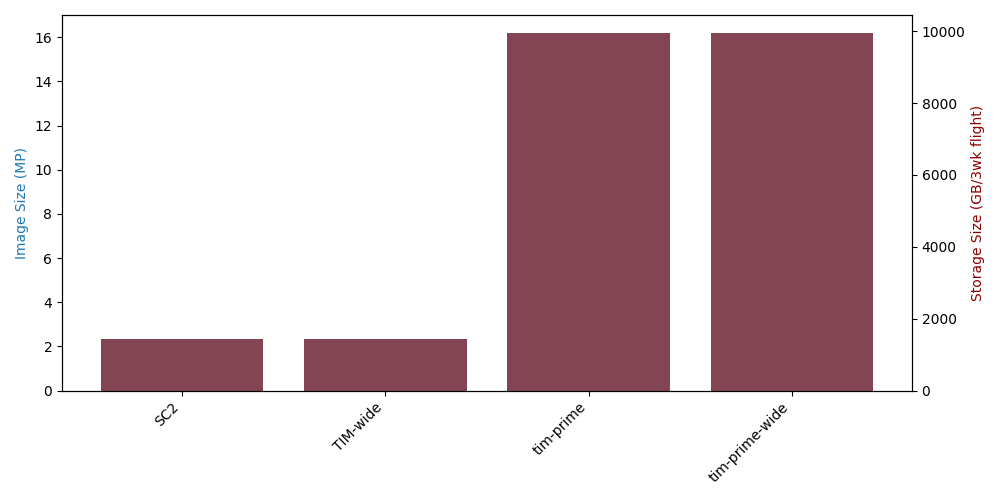

In [15]:
float_time = 8 * 3600 * u.s + (3 * 7 * 24 * 3600) * u.s
cadence = 3 * u.s
num_pics = float_time / cadence
print(f'For a total mission time of {float_time * (u.hr / (3600. * u.s))}, @ cadence {cadence}:')
for cam in cams:
    print(f'{cam.name}: {cam.sensor.megapixels:.1f} MP, {cam.sensor.frame_storage_size / 1e6 / 8:.2f} MB per pic, {num_pics * cam.sensor.frame_storage_size / 1e6 / 8 / 1000:.0f} GB total storage')

fig, megapix = plt.subplots(figsize=(10,5))
megapix.bar([cam.name for cam in cams], [cam.sensor.megapixels for cam in cams], color='C0', alpha=0.6)
megapix.set_ylabel('Image Size (MP)')
megapix.yaxis.label.set_color('C0')
plt.xticks(rotation=45, ha='right')
storage = megapix.twinx()
storage.bar([cam.name for cam in cams], [(num_pics * cam.sensor.frame_storage_size / 1e6 / 8 / 1000) for cam in cams], color='darkred', alpha=0.6)
storage.set_ylabel('Storage Size (GB/3wk flight)')
storage.yaxis.label.set_color('darkred')
fig.tight_layout()

### Cost Optimization

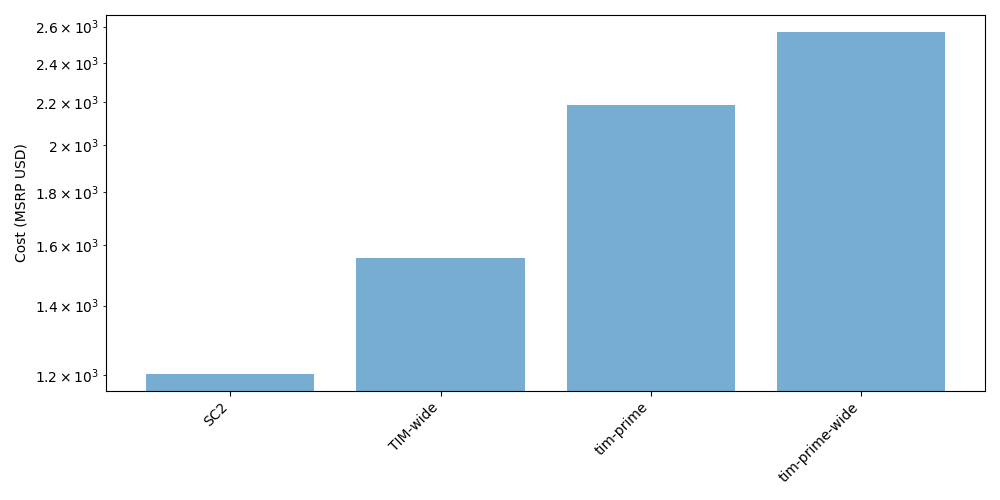

In [16]:
fig, cost = plt.subplots(figsize=(10,5))
cost_sort = np.argsort([cam.cost for cam in cams])
cost.bar([cams[i].name for i in cost_sort], [cams[i].cost for i in cost_sort], color='C0', alpha=0.6)
cost.set_ylabel('Cost (MSRP USD)')
cost.set_yscale('log')
plt.xticks(rotation=45, ha='right')
fig.tight_layout()

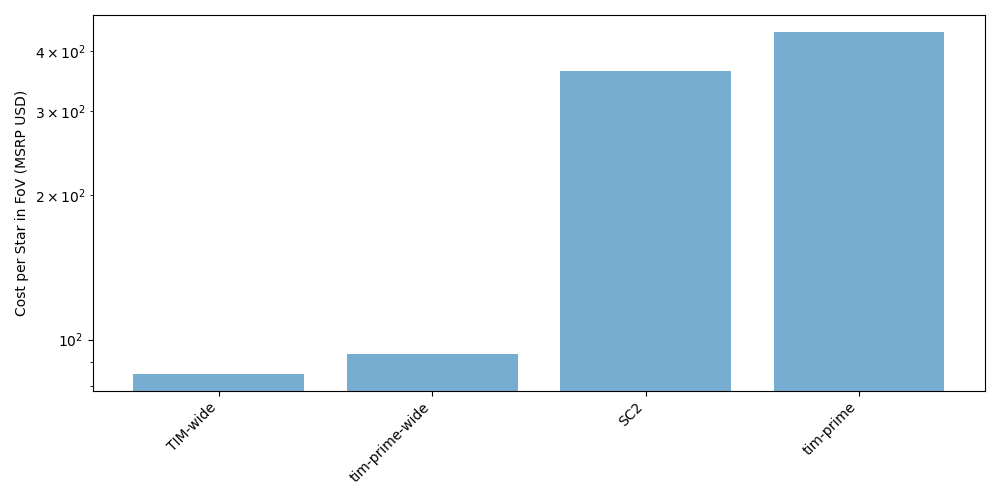

In [17]:
fig, cost = plt.subplots(figsize=(10,5))
cost_sort = np.argsort([cam.cost / ((cam.fov[0] * cam.fov[1]) * I_band_stars_per_deg2) for cam in cams])
cost.bar(
    [cams[i].name for i in cost_sort],
    [cams[i].cost / ((cams[i].fov[0] * cams[i].fov[1]) * I_band_stars_per_deg2) for i in cost_sort],
    color='C0',
    alpha=0.6
)
cost.set_ylabel('Cost per Star in FoV (MSRP USD)')
plt.xticks(rotation=45, ha='right')
cost.set_yscale('log')
fig.tight_layout()

## Recommendations

<font color='red'>TODO: revisit recommendations. New predictions suggest that wide FoV might win out due to catching more bright stars, even if poor pixel matching throws away SNR.</font>

### TIM Science Flight

<hr>

For TIM science flight, I recommend choosing the iDS uEye U3-31N0SE-M-GL. It should net ~5 stars on average over a 10deg^2 FoV at SNR > 2. It has the highest cost overall and highest cost per star, but shooting in 8bit allows us to avoid extensive rewriting of existing software and tamps down the data storage problem to a single ~12 TB drive in flight.

An additional ~40% SNR boost for any of these sensors could be gained by switching to an f/2 lens. We would have to buy secondhand lenses, and re-buy filters for the filter drawers on the f/2 lens; the front element is so large that filters are impractical and are instead installed at the rear.

I do not recommend further filtering into the IR than our existing Tiffen R29 (650 nm). Si-based sensors' QE limitations at ~1000 nm mean that further filtering decreases the total number of photons available from stars and begins eating into SNR, despite the reduction in background, which is flattening the further we push into SWIR. For similar reasons, narrowband interference filters like Halpha are not recommended.

### New Development

<hr>

If new development is pursued for risk reduction, I propose developing a "widefield" option: A Canon 200mm f/2.8 EF lens coupled via the same Birger focuser to a ZWO ASI294MM. Widefield star camera images have distinct advantages, if the PSF matching problem can be overcome - TIM's primary science field is not in the galactic plane, so we should expect fewer stars per image than average. We should try to maximize the number of candidate stars in a given image.

Advantages:
* Wide FoV: ~20.6deg^2, ~10.3 stars, drastically improving chances of successful plate solve
* Sufficient SNR~2 over wider field than TIM test flight due to smaller pixels and higher red QE
* Low data storage requirements
* Software rewrite an opportunity to use more ADC bits, diversify codebase to amortize risk
* Small cost per star in FoV

Risks:
1. SNR still low on 9th mag stars
2. Software rewrite for ZWO API
3. Software effort to adhere to existing flight software interfaces
4. Increased storage requirements

Risk Mitigations:
1. Double exposure time to 0.2s to increase SNR from 4.6 um pixel mismatch
2. Existing ZWO C/Python API examples, ECM has working Python tetra3 plate solver
3. --
4. Run widefield SC at lower cadence to reduce storage requirements

### SWIR

<hr>

I also explored a high-MP (~5 MP) SWIR camera, based on Sony's newest high resolution sensor model, IMX992. This sensor began appearing in COTS integrators' offerings in [Dec. 2024](https://www.framos.com/en/news/sonys-wide-spectrum-image-sensors-imx992-imx993). There is [evidence](https://www.qhyccd.com/scientific-camera-qhy990_qhy991_qhy992/) of daytime operation on stars. The sensor has extreme SWIR QE (>70% at 1000 nm), which supports much more aggressive filtering out past ~800 nm. Current InGaAs technology has low pixel density and somewhat high pixel size, making it difficult to sample the lens PSF. However, the additional background hit from failing to match pixel size to PSF is mitigated by increased SWIR sensitivity. This opens up a new regime for daytime star camera design - high SNR on wide fields:

* Extreme SNR on typical field sizes:
    * SNR = 11 on a 9th mag star
    * 3.7 x 3 deg FoV - ~6 stars
    * ~5.2 arcsec/px
* Balance of SNR and plate scale:
    * SNR = 11 on a 9th mag star
    * 5.9 x 4.8 deg FoV - ~14 stars
    * ~8.4 arcsec/px - lower astrometric precision
* Widen FoV until SNR is similar to Si-based sensors:
    * SNR = 4 on a 9th mag star
    * 10 x 8 deg FoV - ~41 stars
    * ~14.2 arcsec/px - lower astrometric precision

Each option is based on a Canon EF lens compatible with the current Birger focuser.

SWIR sensors require active cooling to control dark current, which adds complexity to the design - TIM would need additional strapping to offload heat from the sensor + TEC via the sensor package. Cost is also extremely high - ~$20,400 for a single sensor.

All options would have moderate storage requirements compared to the APS-C-sized, high-density sensors that would be required to get a similar SNR/FoV combination by exploiting small pixels. But if you're going to pony up >$20,000, you probably don't care about a few hundred bucks in hard drives...

Caveats:
* Stellar flux for SNR is based on magnitudes vs. I-band zero-point flux - essentially assumes constant flux density out into the SWIR, which cannot be true, and should be wrong (too high) by a factor of a few judging from a blackbody curve
    * Cousins R zero-point flux ~6x greater than J
    * I should at least look for zero-point fluxes in other filters that are better matched to the coverage of particular filter+QE combos
    * BB model as input, rather than filter zero-points and stellar magnitudes?
* Conventional photographic lenses may have poor transmission and poor correction/ultimate focus in SWIR - this is not modeled. SWIR lenses are available at additional cost, but are not typically high focal lengths (~12 mm?), and would require a customized focusing solution. WASP (Scott Heatwole) uses a [micro linear stage](https://www.newscaletech.com/micro-motion-modules/m3-ls-linear-smart-stages/) for focusing.